In [1]:
import pickle
import pandas as pd
import spacy
import numpy as np
import collections
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.neural_network
#nlp = spacy.load('en')

In [2]:
with open('data/parsed_text.pic', 'rb') as f:
    doc_data = pickle.load(f)
print(doc_data.keys())
doc_data['good'][0]

dict_keys(['good', 'bad', 'slowed', 'rec'])


The type of research I was working on and the flexibility I had on selecting which problems to focus on.

In [3]:
tokenized = dict()
for q, docs in doc_data.items():
    tokenized[q] = [[tok.lower_ for tok in doc if not tok.is_stop and not tok.is_punct and not tok.like_num and not tok.is_space] for doc in docs]
tokenized['good'][0][:10]

['type',
 'research',
 'working',
 'flexibility',
 'selecting',
 'problems',
 'focus']

## TF-IDF and Comparisons

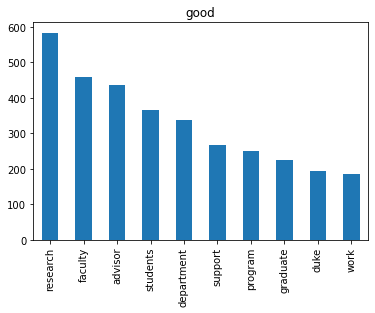

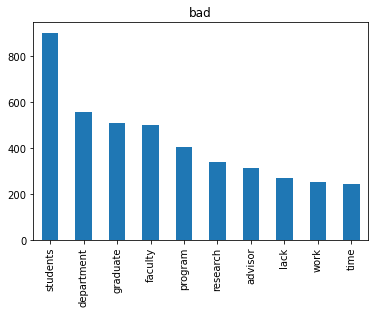

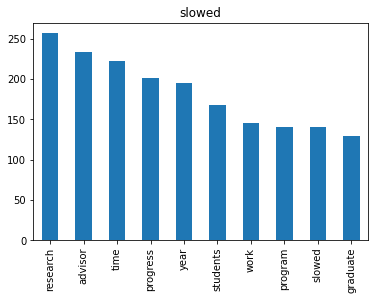

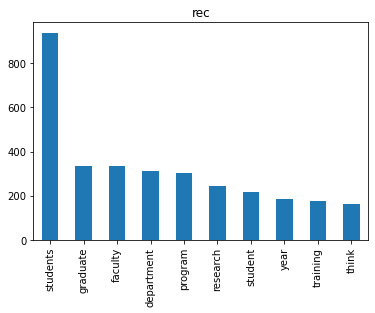

In [4]:
import matplotlib.pyplot as plt

for q, resps in tokenized.items():
    cts = collections.Counter([t for resp in resps for t in resp])
    s = pd.Series(cts).sort_values(ascending=False).head(10)
    s.plot.bar(title=q)
    plt.show()

In [5]:
scounts = dict()
for q, resps in tokenized.items():
    cts = collections.Counter([t for resp in resps for t in resp])
    sct = pd.Series(cts).sort_values(ascending=False)
    scounts[q] = sct/sct.sum()
df = pd.DataFrame(scounts)
#df = df.fillna(0)
df = df.dropna()
df.head(3)

,good,bad,slowed,rec
$,0.000106,0.000698,0.000352,0.000461
+,0.000106,0.000243,0.000422,0.000084
1st,0.000053,0.000061,0.000141,0.000336


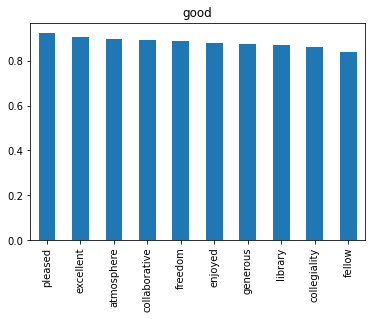

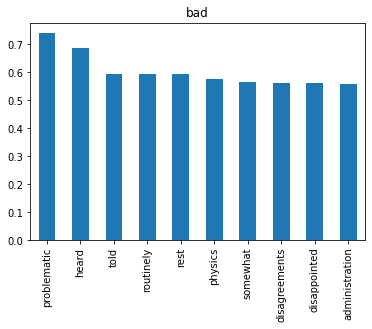

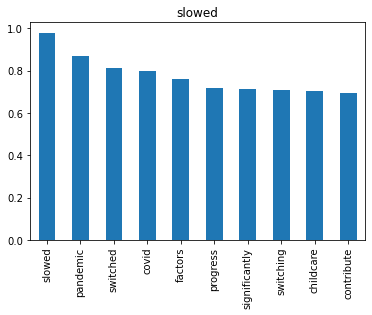

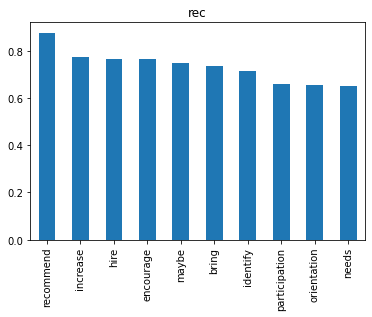

In [6]:
sdf = df.copy()
rowsums = sdf.sum(axis=1)
colnames = list(df.columns)
for col in colnames:
    sdf[col] = sdf[col]/rowsums
    #sdf[col].sort_values(ascending=False)
    sdf[col].sort_values(ascending=False).head(10).plot.bar(title=col)
    plt.show()
#sdf['good'].sort_values(ascending=False)#.filter(lambda x: x < 1)

## BoW/DTM Representations

In [7]:
all_docs = [(q,toks) for q,resps in tokenized.items() for toks in resps]
questions = [q for q,d in all_docs]
responses = [d for q,d in all_docs]
responses[0]

['type',
 'research',
 'working',
 'flexibility',
 'selecting',
 'problems',
 'focus']

In [8]:
min_tf = 50
vectorizer = CountVectorizer(tokenizer = lambda x: x, preprocessor=lambda x:x, min_df=min_tf)
SPARSE_DTM = vectorizer.fit_transform(responses) # get sparse matrix format
vocab = vectorizer.get_feature_names()
DTM = SPARSE_DTM.toarray()
len(vocab), type(SPARSE_DTM), SPARSE_DTM.shape, DTM.shape

(295, scipy.sparse.csr.csr_matrix, (12968, 295), (12968, 295))

In [9]:
SPARSE_DTM.shape[1]

295

In [10]:
# co-occurrence matrix 1: loop through vocab
from scipy.stats.stats import pearsonr
for i in range(SPARSE_DTM.shape[1]):
    for j in range(SPARSE_DTM.shape[1]):
        if i != j:
            x, y = SPARSE_DTM[:,i].toarray().flatten(), SPARSE_DTM[:,j].toarray().flatten()
            r, pv = pearsonr(x,y)
            if pv < 0.00001:
                print(f'{vocab[i]} <-> {vocab[j]}: {r:0.2f} ({pv:0.4f})')
                break
    break

ability <-> campus: 0.06 (0.0000)


In [11]:
co_occur = SPARSE_DTM.T.dot(SPARSE_DTM)#.toarray()
co_occur.setdiag(0)
#co_occur[co_occur < 20] = 0
cdf = pd.DataFrame(co_occur.toarray(), index=vocab, columns=vocab)
cdf.head()

,ability,able,academia,academic,access,actually,advice,adviser,advising,advisor,...,wish,wonderful,work,worked,working,writing,written,year,years,yes
ability,0,4,2,12,2,3,1,0,5,27,...,3,0,44,4,4,3,0,26,17,1
able,4,0,9,28,11,9,7,2,1,97,...,2,3,99,9,6,15,5,91,88,2
academia,2,9,0,43,2,2,2,3,0,22,...,16,3,26,2,11,4,3,19,10,3
academic,12,28,43,0,16,18,10,5,20,120,...,13,4,98,8,18,25,9,87,92,3
access,2,11,2,16,0,8,2,0,2,15,...,1,3,68,3,6,1,0,38,24,1


In [12]:
import networkx as nx
g = nx.from_pandas_adjacency(cdf)
print(g, len(g.edges()), len(g.nodes()))
rm_edges = [(u,v) for u,v,ed in g.edges(data=True) if ed['weight'] < 30]
g.remove_edges_from(rm_edges)
print(len(g.edges()), len(g.nodes()))
nx.write_gexf(g, 'tmp.gexf')

Graph with 295 nodes and 39275 edges 39275 295
3841 295


In [13]:
#networkx.algorithms.community
comms = nx.algorithms.community.greedy_modularity_communities(g, weight='weight', resolution=1) #high resolution -> smaller communities
for com in comms:
    print(com)

frozenset({'meetings', 'particular', 'clear', 'making', 'curriculum', 'preparation', 'interactions', 'quality', 'little', 'exam', 'departmental', 'qualifying', 'fields', 'hard', 'aspects', 'health', 'advice', 'bit', 'member', 'expected', 'dgs', 'believe', 'culture', 'mentorship', 'preliminary', 'study', 'seminars', 'collegial', 'mentor', 'limited', 'worked', 'wish', 'committee', 'primary', 'times', 'written', 'structure', 'small', 'competitive', 'social', 'guidance', 'community', 'change', 'different', 'adviser', 'getting', 'faculty', 'changed', 'including', 'intellectual', 'nice', 'issues', 'provided', 'focus', 'exams', 'area', 'fact', 'guidelines', 'personal', 'flexibility', 'strong', 'going', 'interest', 'left', 'collaboration', 'science', 'certain', 'expectations', 'specific', 'members', 'problem', 'overall', 'general', 'care', 'prelim', 'atmosphere', 'terms', 'helped', 'studies', 'problems', 'mental', 'communication', 'defense', 'example', 'particularly', 'advising', 'areas', 'lea

Use PCA to reduce dimensionality.

In [14]:
clf = TruncatedSVD(100)
Xpca = clf.fit_transform(DTM)
Xpca

array([[ 0.2595157 , -0.60846707, -0.18117282, ..., -0.04073456,
         0.17382835, -0.09849373],
       [ 0.60091114, -1.16442999, -0.34426296, ..., -0.07408073,
        -0.12184722, -0.03186357],
       [ 0.37890274, -0.10771633,  0.82128191, ...,  0.05168933,
        -0.07644119, -0.13032758],
       ...,
       [ 0.80047334, -0.45147995,  0.6215057 , ..., -0.09106036,
         0.03251472,  0.31843102],
       [-0.        , -0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        ,  0.        , ..., -0.        ,
        -0.        , -0.        ]])

# Demographic Regression Models

In [15]:
min_tf = 5
vectorizer = CountVectorizer(tokenizer = lambda x: x, preprocessor=lambda x:x, min_df=min_tf)
corpus_good = vectorizer.fit_transform(tokenized['good'])
vocab_good = vectorizer.get_feature_names()
DTM_good = corpus_good.toarray()
voc2id = {w:i for i,w in enumerate(vocab_good)}
len(vocab_good), type(corpus_good), corpus_good.shape, DTM_good.shape

(616, scipy.sparse.csr.csr_matrix, (3242, 616), (3242, 616))

In [16]:
df = pd.read_csv('data/exit_survey.csv', skiprows=[1,2], usecols=['Q65', 'Q69'])
print(df.shape)
df['mention_advisor'] = DTM_good[:,voc2id['advisor']]
df['mention_lab'] = DTM_good[:,voc2id['lab']]
df['num_words'] = DTM_good.sum(axis=1)
df.head(2)

(3242, 2)


,Q65,Q69,mention_advisor,mention_lab,num_words
0,Male,White (non-Hispanic),0,0,5
1,Female,White (non-Hispanic),1,0,8


In [17]:
import statsmodels.formula.api as smf
mod = smf.ols('mention_advisor ~ Q65 + num_words', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        mention_advisor   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     154.4
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           1.89e-64
Time:                        16:52:09   Log-Likelihood:                -1210.9
No. Observations:                2904   AIC:                             2428.
Df Residuals:                    2901   BIC:                             2446.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0855      0.012      7.428      

In [18]:
mod = smf.ols('mention_lab ~ Q65 + num_words', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            mention_lab   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     60.84
Date:                Tue, 12 Jul 2022   Prob (F-statistic):           1.31e-26
Time:                        16:52:09   Log-Likelihood:                 573.57
No. Observations:                2904   AIC:                            -1141.
Df Residuals:                    2901   BIC:                            -1123.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0161      0.006      2.585      

## Classification

In [19]:
nn = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=[100])
nn.fit(Xpca, questions)

/home/devin/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=[100])

In [20]:
predicted_questions = list(nn.predict(Xpca))
np.mean([q==pq for q,pq in zip(questions, predicted_questions)])

0.5733343615052436

## Doc Vectors
Each row is a document vector.

In [21]:
clf = TruncatedSVD(100)
docvecs = clf.fit_transform(DTM)
docvecs.shape

(12968, 100)

In [22]:
target = docvecs[0]
#target.dot()
docvecs.dot(target)

array([2.36260662, 1.14200097, 0.10349113, ..., 0.17803404, 0.        ,
       0.        ])

### Topic Modeling

In [23]:
# non-negative matrix factorization (similar to pca but for only positive-entry matrices)
nmf_model = NMF(n_components=3).fit(DTM)
doc_topics = nmf_model.transform(DTM)
topic_words = nmf_model.components_
topic_words.shape, doc_topics.shape

((3, 295), (12968, 3))

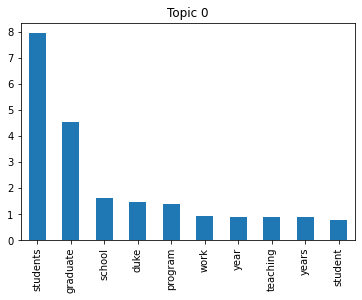

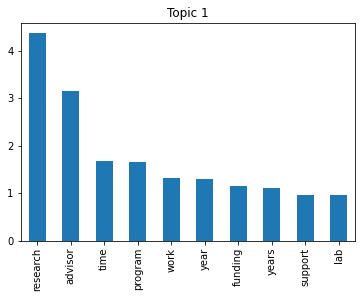

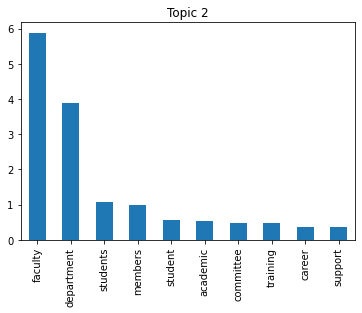

In [24]:
def show_topics(vocab, topic_words, topic):
    s = pd.Series({v:p for v,p in zip(vocab, topic_words[topic])})
    s.sort_values(ascending=False).head(10).plot.bar(title=f'Topic {topic}')
    
for i in range(topic_words.shape[0]):
    show_topics(vocab, topic_words, i)
    plt.show()